# Chronicle Flood Database Analysis

This notebook provides a comprehensive analysis of the Chronicle urban flood dataset, containing over 880,000 flood events worldwide from 2000-2025.

## Dataset Overview
- **Source**: Chronicle preliminary dataset (HUJI)
- **Records**: 882,972 flood events
- **Time Period**: 2000-2025
- **Geographic Coverage**: Global
- **Data Format**: CSV with WKT geometry

## 1. Import Libraries and Setup

In [1]:
# Core data analysis libraries
import pandas as pd
import numpy as np
from datetime import datetime
import math

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely import wkt
from matplotlib.patches import Polygon as MplPolygon, Rectangle, Circle
import folium
from folium import plugins

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 2. Data Loading and Initial Exploration

In [2]:
# Load the Chronicle dataset
file_path = r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_preliminary_huji.csv"

try:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully: {df.shape[0]:,} records, {df.shape[1]} columns")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except FileNotFoundError:
    print("Error: Dataset file not found. Please check the file path.")
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully: 882,972 records, 8 columns
Memory usage: 490.17 MB


In [3]:
# Dataset structure overview
print("Dataset Information:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nData types:")
df.info()

Dataset Information:
Shape: (882972, 8)

Columns: ['Unnamed: 0', 'uuid', 'area_km2', 'version', 'start_time', 'end_time', 'duration_days', 'geometry_wkt']

Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882972 entries, 0 to 882971
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     882972 non-null  int64  
 1   uuid           882972 non-null  object 
 2   area_km2       882972 non-null  float64
 3   version        882972 non-null  object 
 4   start_time     882972 non-null  float64
 5   end_time       882972 non-null  float64
 6   duration_days  882972 non-null  int64  
 7   geometry_wkt   882972 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 53.9+ MB


In [4]:
# Sample records
print("Sample records:")
display(df.head())

print(f"\nBasic statistics:")
display(df.describe())

Sample records:


,Unnamed: 0,uuid,area_km2,version,start_time,end_time,duration_days,geometry_wkt
0,0,93e48341dbaa4be29a38b856d94206c5,191.436317,v3.1,946684800.0,946684800.0,1,"POLYGON ((-7.6844751 33.499789, -7.5516781 33...."
1,1,939149831ea34c3e94712cc42c17c46a,14.208894,v3.1,946684800.0,946684800.0,1,"POLYGON ((-7.9863739 29.745153, -7.9965878 29...."
2,2,931831f75479454cb3938811e64ce882,28.562733,v3.1,946684800.0,946684800.0,1,"POLYGON ((-98.97432499999999 19.337026, -98.93..."
3,3,91bc68dde43646289c9e75b7d59e1711,108.562378,v3.1,946684800.0,946684800.0,1,"POLYGON ((30.936502 -29.872152, 30.928104 -29...."
4,4,8b849511de80423f98918f55af323e7e,0.104375,v3.1,946684800.0,946684800.0,1,"POLYGON ((16.547385 38.687964, 16.549982 38.68..."



Basic statistics:


,Unnamed: 0,area_km2,start_time,end_time,duration_days
count,882972.000000,882972.000000,8.829720e+05,8.829720e+05,882972.000000
mean,441485.500000,226.346070,1.586577e+09,1.586640e+09,1.719860
std,254892.205282,663.366813,1.452755e+08,1.452781e+08,1.136585
min,0.000000,0.000007,9.466848e+08,9.466848e+08,1.000000
25%,220742.750000,2.501578,1.504829e+09,1.504915e+09,1.000000
50%,441485.500000,12.233674,1.623629e+09,1.623715e+09,1.000000
75%,662228.250000,71.604724,1.704672e+09,1.704758e+09,2.000000
max,882971.000000,4998.975299,1.761437e+09,1.761437e+09,7.000000


## 3. Data Quality Assessment

In [5]:
# Data completeness and quality checks
print("Data Quality Assessment:")
print(f"\nMissing values:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

print(f"\nDuplicate records: {df.duplicated().sum():,}")
print(f"Unique UUIDs: {df['uuid'].nunique():,} (should match total records)")

print(f"\nVersion distribution:")
print(df['version'].value_counts())

print(f"\nGeometry types:")
geometry_types = df['geometry_wkt'].str.extract(r'^(\w+)')[0].value_counts()
print(geometry_types)

Data Quality Assessment:

Missing values:
Series([], dtype: int64)

Duplicate records: 0
Unique UUIDs: 882,972 (should match total records)

Version distribution:
v3.1    882972
Name: version, dtype: int64

Geometry types:
POLYGON         814716
MULTIPOLYGON     68256
Name: 0, dtype: int64


## 4. Temporal Analysis

In [6]:
# Convert timestamps and analyze temporal patterns
print("Temporal Analysis:")

# Time range analysis
min_start = datetime.fromtimestamp(df['start_time'].min())
max_start = datetime.fromtimestamp(df['start_time'].max())
min_end = datetime.fromtimestamp(df['end_time'].min())
max_end = datetime.fromtimestamp(df['end_time'].max())

print(f"\nTime coverage:")
print(f"Start times: {min_start.strftime('%Y-%m-%d')} to {max_start.strftime('%Y-%m-%d')}")
print(f"End times: {min_end.strftime('%Y-%m-%d')} to {max_end.strftime('%Y-%m-%d')}")

# Duration analysis
duration_stats = df['duration_days'].describe()
print(f"\nDuration statistics (days):")
print(f"Range: {df['duration_days'].min()} to {df['duration_days'].max()}")
print(f"Mean: {duration_stats['mean']:.2f}, Median: {duration_stats['50%']:.2f}")

print(f"\nMost common durations:")
print(df['duration_days'].value_counts().head())

Temporal Analysis:

Time coverage:
Start times: 2000-01-01 to 2025-10-26
End times: 2000-01-01 to 2025-10-26

Duration statistics (days):
Range: 1 to 7
Mean: 1.72, Median: 1.00

Most common durations:
1    516380
2    223153
3     74979
4     34426
5     17409
Name: duration_days, dtype: int64


## 5. Spatial Analysis

In [7]:
import numpy as np

# --- CONFIGURATION ---
# Set the threshold area in square kilometers
# You can try changing this to 0.1, 0.5, or keep it at 1.0
THRESHOLD_KM2 = 0.25
# ---------------------

print("--- Flood Area Analysis & Threshold Check ---")

# 1. General Statistics
area_stats = df['area_km2'].describe()
print(f"\n1. General Statistics (km²):")
print(f"   Range: {df['area_km2'].min():.6f} to {df['area_km2'].max():.2f}")
print(f"   Mean: {area_stats['mean']:.2f}")
print(f"   Median: {area_stats['50%']:.2f}")

# 2. Threshold Analysis
# Split the data based on the threshold
small_polygons = df[df['area_km2'] < THRESHOLD_KM2]
valid_polygons = df[df['area_km2'] >= THRESHOLD_KM2]

count_total = len(df)
count_small = len(small_polygons)
count_valid = len(valid_polygons)

print(f"\n2. Threshold Analysis (Cutoff: {THRESHOLD_KM2} km²):")
print(f"   Total Events: {count_total}")
print(f"   [+] Valid Events (>= {THRESHOLD_KM2} km²): {count_valid} ({count_valid/count_total:.1%})")
print(f"   [-] Too Small Events (< {THRESHOLD_KM2} km²): {count_small} ({count_small/count_total:.1%})")

# 3. Percentiles (To see where the threshold lands)
percentiles = [10, 25, 50, 75, 90]
print(f"\n3. Area Percentiles (km²):")
for p in percentiles:
    value = np.percentile(df['area_km2'], p)
    marker = " <--- THRESHOLD IS HERE" if (value >= THRESHOLD_KM2 and np.percentile(df['area_km2'], p-10 if p>10 else 0) < THRESHOLD_KM2) else ""
    print(f"   {p}th percentile: {value:.4f} {marker}")

# 4. Recommendation based on 100m resolution
# A 100m pixel covers 0.01 km². Ideally, we want at least 4-9 pixels for minimal validity.
min_recommended_area = 0.04 # 4 pixels
print(f"\n--- Technical Note ---")
print(f"With 100m resolution, 1 pixel = 0.01 km².")
print(f"Your chosen threshold of {THRESHOLD_KM2} km² gives ~{int(THRESHOLD_KM2/0.01)} pixels per polygon.")
if THRESHOLD_KM2 >= 0.1:
    print("Verdict: Excellent accuracy expected.")
else:
    print("Verdict: Borderline accuracy (few pixels per polygon).")

--- Flood Area Analysis & Threshold Check ---

1. General Statistics (km²):
   Range: 0.000007 to 4998.98
   Mean: 226.35
   Median: 12.23

2. Threshold Analysis (Cutoff: 0.25 km²):
   Total Events: 882972
   [+] Valid Events (>= 0.25 km²): 845720 (95.8%)
   [-] Too Small Events (< 0.25 km²): 37252 (4.2%)

3. Area Percentiles (km²):
   10th percentile: 0.6419  <--- THRESHOLD IS HERE
   25th percentile: 2.5016 
   50th percentile: 12.2337 
   75th percentile: 71.6047 
   90th percentile: 543.4847 

--- Technical Note ---
With 100m resolution, 1 pixel = 0.01 km².
Your chosen threshold of 0.25 km² gives ~25 pixels per polygon.
Verdict: Excellent accuracy expected.


## 6. Statistical Visualizations

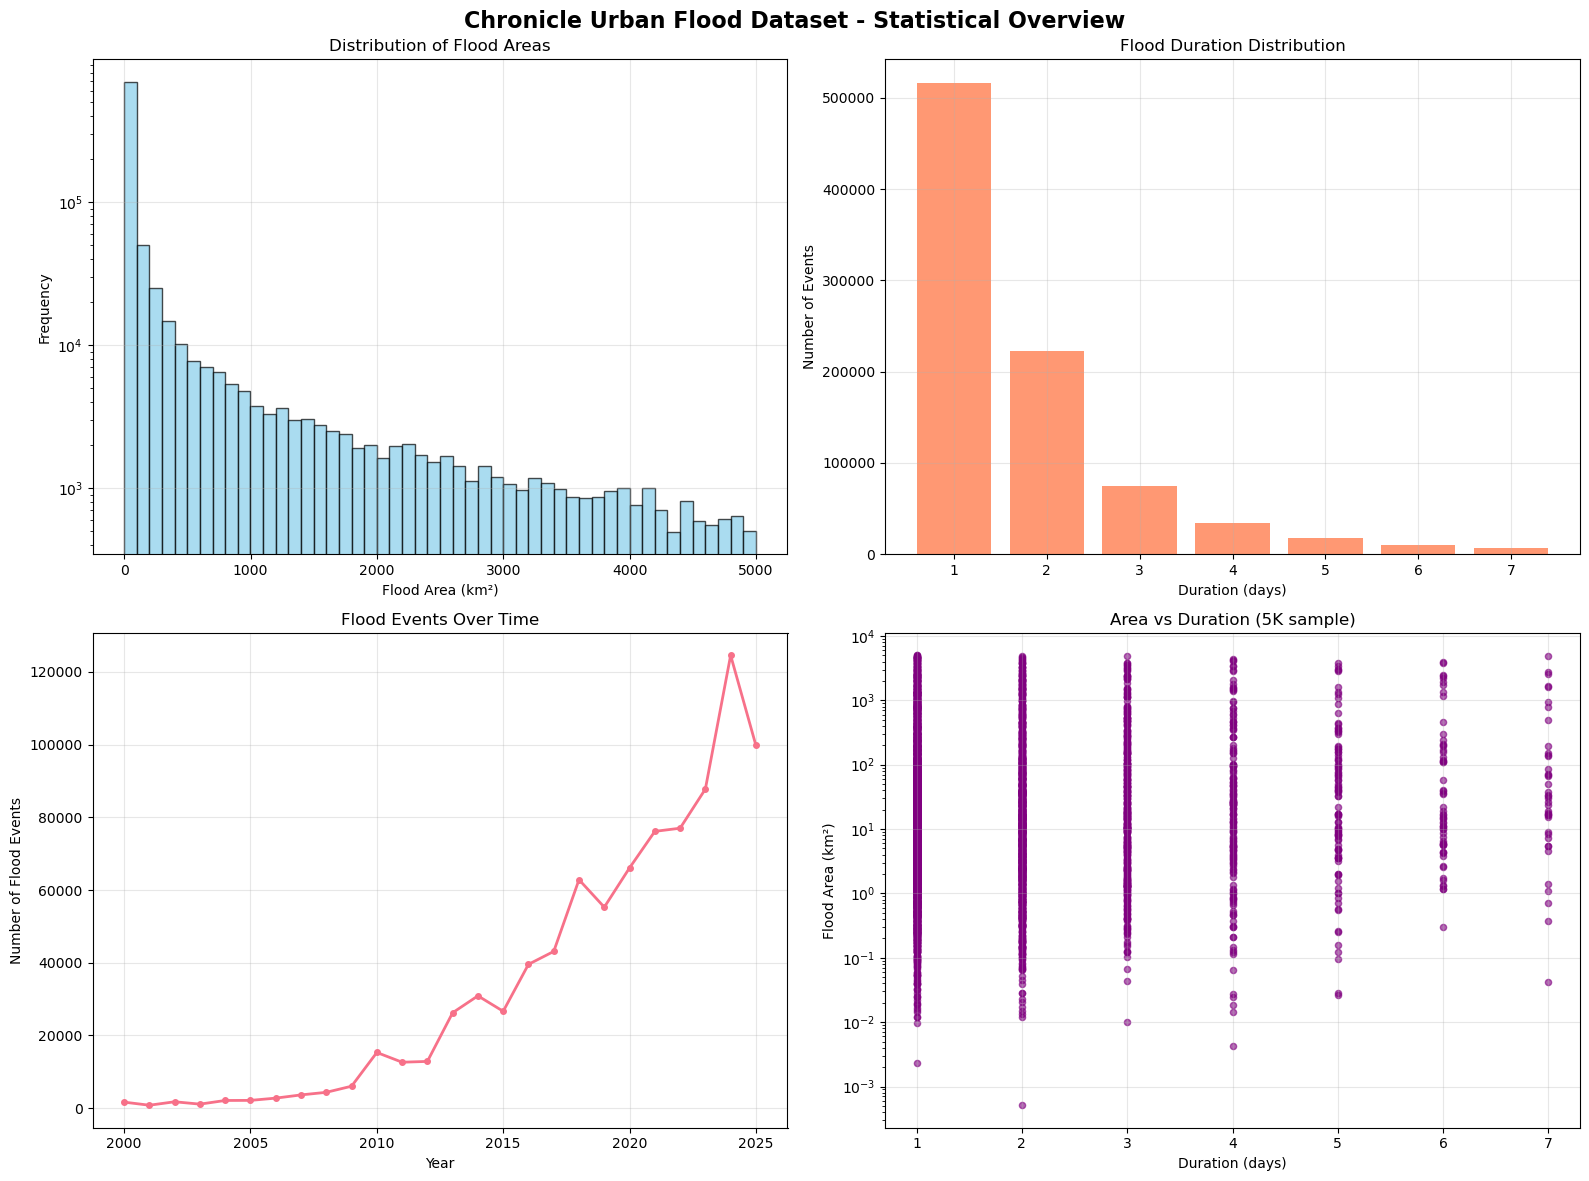

Temporal coverage: 2000 - 2025
Peak year: 2024 (124,580 events)
Most common duration: 1 day(s) (516,380 events)


In [8]:
# Create comprehensive statistical visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Chronicle Urban Flood Dataset - Statistical Overview', fontsize=16, fontweight='bold')

# 1. Flood area distribution (log scale)
axes[0,0].hist(df['area_km2'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Flood Area (km²)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Flood Areas')
axes[0,0].set_yscale('log')
axes[0,0].grid(True, alpha=0.3)

# 2. Duration distribution
duration_counts = df['duration_days'].value_counts().sort_index()
axes[0,1].bar(duration_counts.index, duration_counts.values, color='coral', alpha=0.8)
axes[0,1].set_xlabel('Duration (days)')
axes[0,1].set_ylabel('Number of Events')
axes[0,1].set_title('Flood Duration Distribution')
axes[0,1].grid(True, alpha=0.3)

# 3. Temporal distribution by year
df_temp = df.copy()
df_temp['year'] = pd.to_datetime(df_temp['start_time'], unit='s').dt.year
yearly_counts = df_temp['year'].value_counts().sort_index()

axes[1,0].plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=4)
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Number of Flood Events')
axes[1,0].set_title('Flood Events Over Time')
axes[1,0].grid(True, alpha=0.3)

# 4. Area vs Duration relationship
sample_df = df.sample(n=5000, random_state=42)
scatter = axes[1,1].scatter(sample_df['duration_days'], sample_df['area_km2'], 
                           alpha=0.6, s=20, c='purple')
axes[1,1].set_xlabel('Duration (days)')
axes[1,1].set_ylabel('Flood Area (km²)')
axes[1,1].set_title('Area vs Duration (5K sample)')
axes[1,1].set_yscale('log')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"Temporal coverage: {yearly_counts.index.min()} - {yearly_counts.index.max()}")
print(f"Peak year: {yearly_counts.idxmax()} ({yearly_counts.max():,} events)")
print(f"Most common duration: {duration_counts.idxmax()} day(s) ({duration_counts.max():,} events)")

## 7. Geographic Distribution Analysis

In [9]:
# Extract coordinates from geometry for geographic analysis
def extract_centroid_coordinates(geometry_wkt_string):
    """Extract centroid coordinates from WKT geometry string."""
    try:
        if geometry_wkt_string.startswith(('POLYGON', 'MULTIPOLYGON')):
            geom = wkt.loads(geometry_wkt_string)
            centroid = geom.centroid
            return centroid.y, centroid.x  # lat, lon
    except Exception:
        return None, None
    return None, None

# Process sample for geographic visualization
sample_size = 9000
sample_events = df.sample(n=sample_size, random_state=42)

print(f"Processing {sample_size} events for geographic analysis...")

coordinates = []
areas = []
durations = []

for idx, row in sample_events.iterrows():
    lat, lon = extract_centroid_coordinates(row['geometry_wkt'])
    if lat is not None and lon is not None:
        coordinates.append([lon, lat])  # lon, lat order
        areas.append(row['area_km2'])
        durations.append(row['duration_days'])

coordinates = np.array(coordinates)
lons = coordinates[:, 0]
lats = coordinates[:, 1]
areas_array = np.array(areas)

print(f"Successfully processed {len(coordinates)} events")

Processing 9000 events for geographic analysis...
Successfully processed 9000 events


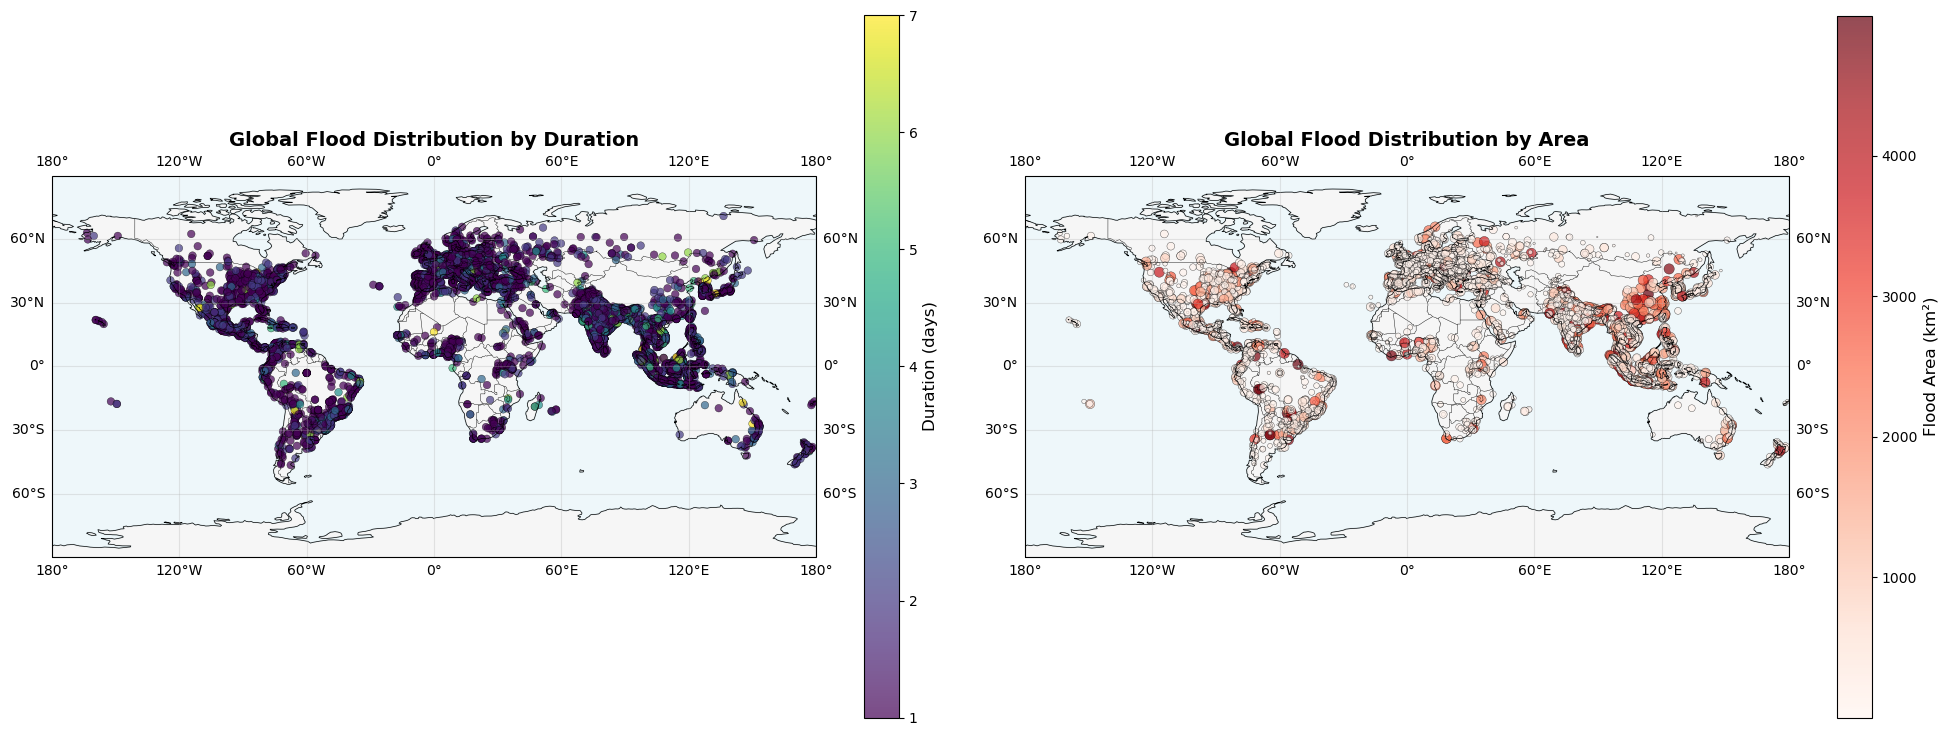

In [10]:
# Create global distribution maps
fig = plt.figure(figsize=(20, 12))

# Map 1: Distribution by duration
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_global()
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linewidth=0.3)
ax1.add_feature(cfeature.LAND, alpha=0.2, color='lightgray')
ax1.add_feature(cfeature.OCEAN, alpha=0.2, color='lightblue')

scatter1 = ax1.scatter(lons, lats, c=durations, s=30, alpha=0.7, 
                      cmap='viridis', transform=ccrs.PlateCarree(), 
                      edgecolors='black', linewidth=0.3)
ax1.set_title('Global Flood Distribution by Duration', fontsize=14, fontweight='bold')
ax1.gridlines(draw_labels=True, alpha=0.3)

cbar1 = plt.colorbar(scatter1, ax=ax1, shrink=0.6, pad=0.05)
cbar1.set_label('Duration (days)', fontsize=12)

# Map 2: Distribution by area
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_global()
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=0.3)
ax2.add_feature(cfeature.LAND, alpha=0.2, color='lightgray')
ax2.add_feature(cfeature.OCEAN, alpha=0.2, color='lightblue')

sizes = np.log10(areas_array + 1) * 15
scatter2 = ax2.scatter(lons, lats, c=areas_array, s=sizes, alpha=0.7, 
                      cmap='Reds', transform=ccrs.PlateCarree(),
                      edgecolors='black', linewidth=0.3)
ax2.set_title('Global Flood Distribution by Area', fontsize=14, fontweight='bold')
ax2.gridlines(draw_labels=True, alpha=0.3)

cbar2 = plt.colorbar(scatter2, ax=ax2, shrink=0.6, pad=0.05)
cbar2.set_label('Flood Area (km²)', fontsize=12)

plt.tight_layout()
plt.show()

In [11]:
# Geographic statistics
print("Geographic Distribution Summary:")
print(f"Latitude range: {lats.min():.2f}° to {lats.max():.2f}°")
print(f"Longitude range: {lons.min():.2f}° to {lons.max():.2f}°")

# Hemisphere distribution
northern_hem = np.sum(lats > 0)
southern_hem = np.sum(lats <= 0)
eastern_hem = np.sum(lons > 0)  
western_hem = np.sum(lons <= 0)

print(f"\nHemisphere Distribution:")
print(f"Northern Hemisphere: {northern_hem:,} events ({northern_hem/len(lats)*100:.1f}%)")
print(f"Southern Hemisphere: {southern_hem:,} events ({southern_hem/len(lats)*100:.1f}%)")
print(f"Eastern Hemisphere: {eastern_hem:,} events ({eastern_hem/len(lons)*100:.1f}%)")
print(f"Western Hemisphere: {western_hem:,} events ({western_hem/len(lons)*100:.1f}%)")

# Continental approximation
continents = {
    'Europe': np.sum((lats > 35) & (lats < 72) & (lons > -10) & (lons < 40)),
    'Asia': np.sum((lats > 10) & (lats < 72) & (lons > 40) & (lons < 180)),
    'North America': np.sum((lats > 15) & (lats < 72) & (lons > -170) & (lons < -50)),
    'Africa': np.sum((lats > -35) & (lats < 35) & (lons > -20) & (lons < 55)),
    'South America': np.sum((lats > -55) & (lats < 15) & (lons > -85) & (lons < -35)),
    'Oceania': np.sum((lats > -50) & (lats < 0) & (lons > 110) & (lons < 180))
}

print(f"\nApproximate Continental Distribution:")
for continent, count in sorted(continents.items(), key=lambda x: x[1], reverse=True):
    if count > 0:
        print(f"{continent}: {count:,} events ({count/len(lats)*100:.1f}%)")

Geographic Distribution Summary:
Latitude range: -46.46° to 70.91°
Longitude range: -163.55° to 179.32°

Hemisphere Distribution:
Northern Hemisphere: 7,072 events (78.6%)
Southern Hemisphere: 1,928 events (21.4%)
Eastern Hemisphere: 6,622 events (73.6%)
Western Hemisphere: 2,378 events (26.4%)

Approximate Continental Distribution:
Europe: 2,688 events (29.9%)
Asia: 2,333 events (25.9%)
North America: 956 events (10.6%)
South America: 769 events (8.5%)
Oceania: 735 events (8.2%)
Africa: 340 events (3.8%)


## 8. Case Study: Detailed Event Analysis

In [12]:
# Simple Event Selection - Choose any event from 1 to 882,972

EVENT_NUMBER = 0  # *** CHANGE THIS NUMBER ***

print(f"Analyzing event number {EVENT_NUMBER:,} out of {len(df):,} total events")
print("To analyze a different event, change EVENT_NUMBER above and re-run the cells below")
print("="*60)

# Get the selected event (convert from 1-based to 0-based index)
sample_event = df.iloc[EVENT_NUMBER - 1]

print("Case Study: Detailed Flood Event Analysis")

# Event details
start_date = datetime.fromtimestamp(sample_event['start_time'])
end_date = datetime.fromtimestamp(sample_event['end_time'])

print(f"Event ID: {sample_event['uuid']}")
print(f"Area: {sample_event['area_km2']:.2f} km²")
print(f"Duration: {sample_event['duration_days']} days")
print(f"Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Version: {sample_event['version']}")

# Parse geometry
geometry_wkt = sample_event['geometry_wkt']
geom = wkt.loads(geometry_wkt)
centroid = geom.centroid
center_lat, center_lon = centroid.y, centroid.x
bounds = geom.bounds

print(f"\nGeographic Information:")
print(f"Center: {center_lat:.4f}°N, {center_lon:.4f}°E")
print(f"Bounding box: {bounds}")
print(f"Geometry type: {geometry_wkt.split('(')[0]}")

# Statistical context
area_rank = (df['area_km2'] >= sample_event['area_km2']).sum()
area_percentile = (df['area_km2'] <= sample_event['area_km2']).sum() / len(df) * 100
duration_percentile = (df['duration_days'] <= sample_event['duration_days']).sum() / len(df) * 100

print(f"\nStatistical Context:")
print(f"Area rank: {area_rank:,} out of {len(df):,} events")
print(f"Area percentile: {area_percentile:.1f}%")
print(f"Duration percentile: {duration_percentile:.1f}%")

Analyzing event number 0 out of 882,972 total events
To analyze a different event, change EVENT_NUMBER above and re-run the cells below
Case Study: Detailed Flood Event Analysis
Event ID: 4f4b5bb45a56407d8aeee1001c0f3a32
Area: 55.45 km²
Duration: 1 days
Period: 2025-10-26 to 2025-10-26
Version: v3.1

Geographic Information:
Center: 15.3941°N, 108.1322°E
Bounding box: (108.09749, 15.330918, 108.15568, 15.432087)
Geometry type: POLYGON 

Statistical Context:
Area rank: 247,334 out of 882,972 events
Area percentile: 72.0%
Duration percentile: 58.5%


## 9. Flood Event Visualization

Local map bounds: 108.0475 to 108.2057 (lon), 15.2809 to 15.4821 (lat)


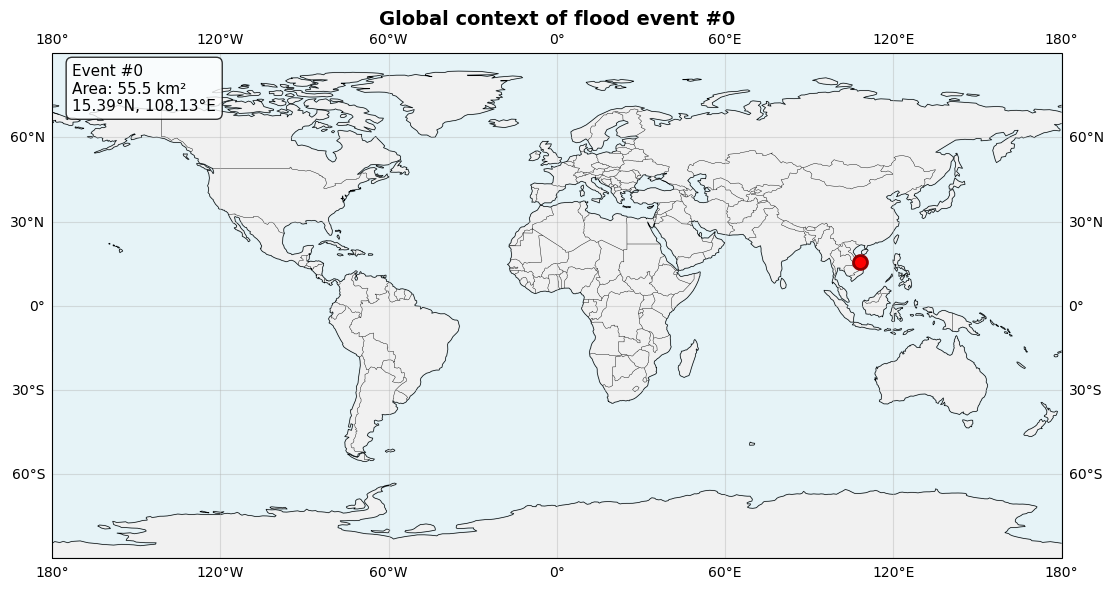

Estimated zoom level for local map: 13
Added flood polygon to local map
Local interactive map ready. Use Streets or Satellite to inspect urban vs non urban context.


C:\Users\raznu\AppData\Local\Temp\ipykernel_11740\1492267495.py:166: UserWarning: color argument of Icon should be one of: {'purple', 'pink', 'red', 'white', 'darkgreen', 'lightgreen', 'green', 'gray', 'lightblue', 'orange', 'beige', 'lightred', 'darkred', 'blue', 'cadetblue', 'darkpurple', 'darkblue', 'black', 'lightgray'}.
  icon=folium.Icon(color="yellow", icon="star", prefix="fa"),


In [13]:
center_lat, center_lon = centroid.y, centroid.x
area_km2 = sample_event["area_km2"]

# Padding around the flood polygon for the local map
if area_km2 < 1:
    padding_deg = 0.02
elif area_km2 < 10:
    padding_deg = 0.03
elif area_km2 < 100:
    padding_deg = 0.05
else:
    padding_deg = 0.08

local_west  = bounds[0] - padding_deg
local_east  = bounds[2] + padding_deg
local_south = bounds[1] - padding_deg
local_north = bounds[3] + padding_deg

print(
    f"Local map bounds: {local_west:.4f} to {local_east:.4f} (lon), "
    f"{local_south:.4f} to {local_north:.4f} (lat)"
)

# --------------------------------------------------------
# 9.1 Global context map (static)
# --------------------------------------------------------

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()

# Basic background
ax.add_feature(cfeature.LAND, alpha=0.3, color="lightgray")
ax.add_feature(cfeature.OCEAN, alpha=0.3, color="lightblue")
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# Flood location
ax.plot(
    center_lon,
    center_lat,
    marker="o",
    markersize=10,
    markerfacecolor="red",
    markeredgecolor="darkred",
    markeredgewidth=2,
    transform=ccrs.PlateCarree(),
)

ax.set_title(
    f"Global context of flood event #{EVENT_NUMBER}",
    fontsize=14,
    fontweight="bold",
)

info_text = (
    f"Event #{EVENT_NUMBER}\n"
    f"Area: {area_km2:.1f} km²\n"
    f"{center_lat:.2f}°N, {center_lon:.2f}°E"
)
ax.text(
    0.02,
    0.98,
    info_text,
    transform=ax.transAxes,
    fontsize=11,
    va="top",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8),
)

ax.gridlines(draw_labels=True, alpha=0.4)
plt.tight_layout()
plt.show()

# --------------------------------------------------------
# 9.2 Local detailed map with “Google style” background (folium)
# --------------------------------------------------------

import folium
from shapely.geometry import mapping

def estimate_zoom(area_km2_value):
    """Heuristic zoom level based on flood area."""
    if area_km2_value < 1:
        return 15
    elif area_km2_value < 10:
        return 14
    elif area_km2_value < 100:
        return 13
    elif area_km2_value < 1000:
        return 12
    else:
        return 11

zoom_start = estimate_zoom(area_km2)
print(f"Estimated zoom level for local map: {zoom_start}")

# Create local interactive map
local_map = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=zoom_start,
    tiles=None,
)

# Streets layer good for seeing urban vs non urban
folium.TileLayer(
    tiles="https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
    attr="© OpenStreetMap contributors",
    name="Streets",
    control=True,
).add_to(local_map)

# Satellite layer similar to Google Maps
folium.TileLayer(
    tiles=(
        "https://server.arcgisonline.com/ArcGIS/rest/services/"
        "World_Imagery/MapServer/tile/{z}/{y}/{x}"
    ),
    attr=(
        "Tiles © Esri. Sources: Esri, i-cubed, USDA, USGS, AEX, GeoEye, "
        "Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community"
    ),
    name="Satellite",
    overlay=False,
    control=True,
).add_to(local_map)

# Fit map to the flood bounding box
local_map.fit_bounds([[local_south, local_west], [local_north, local_east]])

# Add flood polygon
try:
    folium.GeoJson(
        data=mapping(geom),
        name="Flood polygon",
        style_function=lambda feature: {
            "color": "red",
            "weight": 3,
            "fillColor": "red",
            "fillOpacity": 0.35,
        },
        highlight_function=lambda feature: {
            "weight": 4,
            "color": "yellow",
            "fillOpacity": 0.5,
        },
        tooltip=f"Flood area: {area_km2:.1f} km²",
    ).add_to(local_map)

    print("Added flood polygon to local map")

except Exception as e:
    print(f"Could not add polygon, falling back to point marker: {e}")
    folium.CircleMarker(
        location=[center_lat, center_lon],
        radius=10,
        color="red",
        fill=True,
        fill_opacity=0.7,
        popup=f"Flood centroid. Area: {area_km2:.1f} km²",
    ).add_to(local_map)

# Add centroid marker
folium.Marker(
    location=[center_lat, center_lon],
    icon=folium.Icon(color="yellow", icon="star", prefix="fa"),
    tooltip=f"Centroid: {center_lat:.3f}N, {center_lon:.3f}E",
).add_to(local_map)

# Add dashed rectangle showing the local extent
folium.Rectangle(
    bounds=[[local_south, local_west], [local_north, local_east]],
    color="black",
    weight=1,
    fill=False,
    dash_array="5,5",
    tooltip="Local map extent",
).add_to(local_map)

# Layer control
folium.LayerControl(collapsed=False).add_to(local_map)

print("Local interactive map ready. Use Streets or Satellite to inspect urban vs non urban context.")

local_map


## 10. Event Summary

In [14]:
# Selected Event Analysis Summary
print(f"Selected Event #{EVENT_NUMBER} - Complete Analysis")
print("="*60)

print(f"\nEvent Details:")
print(f"• UUID: {sample_event['uuid']}")
print(f"• Date: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"• Duration: {sample_event['duration_days']} days")
print(f"• Area: {sample_event['area_km2']:.2f} km²")
print(f"• Location: {center_lat:.4f}°N, {center_lon:.4f}°E")

print(f"\nStatistical Context:")
print(f"• Area rank: {area_rank:,} out of {len(df):,} total events")
print(f"• Area percentile: {area_percentile:.1f}% (larger than {area_percentile:.1f}% of all events)")
print(f"• Duration percentile: {duration_percentile:.1f}%")

print(f"\nGeographic Context:")
print(f"• Bounding box: {bounds}")
print(f"• Geometry type: {geometry_wkt.split('(')[0]}")

# Determine geographic region
if -180 <= center_lon <= -30:
    region = "Americas"
elif -30 < center_lon <= 60:
    if 35 <= center_lat <= 72:
        region = "Europe"
    elif -35 <= center_lat < 35:
        region = "Africa/Middle East"
    else:
        region = "Other"
elif 60 < center_lon <= 180:
    if center_lat > 10:
        region = "Asia"
    else:
        region = "Oceania"
else:
    region = "Unknown"

print(f"• Approximate region: {region}")

print(f"\nTo analyze a different event:")
print(f"• Change EVENT_NUMBER (currently {EVENT_NUMBER}) in the selection cell above")
print(f"• Choose any number from 1 to {len(df):,}")
print(f"• Re-run the analysis cells to see the new event")

Selected Event #0 - Complete Analysis

Event Details:
• UUID: 4f4b5bb45a56407d8aeee1001c0f3a32
• Date: 2025-10-26 to 2025-10-26
• Duration: 1 days
• Area: 55.45 km²
• Location: 15.3941°N, 108.1322°E

Statistical Context:
• Area rank: 247,334 out of 882,972 total events
• Area percentile: 72.0% (larger than 72.0% of all events)
• Duration percentile: 58.5%

Geographic Context:
• Bounding box: (108.09749, 15.330918, 108.15568, 15.432087)
• Geometry type: POLYGON 
• Approximate region: Asia

To analyze a different event:
• Change EVENT_NUMBER (currently 0) in the selection cell above
• Choose any number from 1 to 882,972
• Re-run the analysis cells to see the new event
